# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://course.cse.ust.hk/comp4901j/Password_Only/programs/assignment1/index.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
from __future__ import print_function

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.396083
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:**
The softmax loss function is $-\log(\frac{e^j}{\sum_i e^i})$, where i is the score for each class and j is the score for the correct class. Since the network is not trained yet, we should have the same score for all classes no matter the input. Therefore, $\frac{e^j}{\sum_i e^i} = \frac{1}{N}$, where N is the number of classes. Here $N=10$, we should expect the loss starts from $-\log(0.1)$


In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -4.567849 analytic: -4.567849, relative error: 7.656932e-09
numerical: -0.435648 analytic: -0.435649, relative error: 1.008929e-07
numerical: -0.519405 analytic: -0.519405, relative error: 3.140552e-08
numerical: -0.040681 analytic: -0.040681, relative error: 7.910315e-09
numerical: 1.424266 analytic: 1.424266, relative error: 3.533189e-08
numerical: 0.781900 analytic: 0.781900, relative error: 4.663677e-08
numerical: 2.551467 analytic: 2.551467, relative error: 1.787668e-08
numerical: -0.978183 analytic: -0.978183, relative error: 2.062217e-08
numerical: 1.363984 analytic: 1.363984, relative error: 9.876413e-09
numerical: -3.107008 analytic: -3.107008, relative error: 2.140834e-09
numerical: -3.085251 analytic: -3.085251, relative error: 2.958194e-09
numerical: 2.191886 analytic: 2.191886, relative error: 2.751208e-08
numerical: 0.487926 analytic: 0.487926, relative error: 1.030383e-08
numerical: 1.048976 analytic: 1.048976, relative error: 2.668739e-08
numerical: -0.466299

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.396083e+00 computed in 0.081232s
vectorized loss: 2.396083e+00 computed in 0.158448s
Loss difference: 0.000000
Gradient difference: 0.000000


In [6]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
learning_rates = np.logspace(-8, -4, 40)
regularization_strengths = np.logspace(1, 6, 10)
results = {}
results_array = np.zeros((regularization_strengths.shape[0], learning_rates.shape[0]))
best_val = -1
best_softmax = None

################################################################################
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for lr in learning_rates:
    tic = time.time()
    for rs in regularization_strengths:
        softm = Softmax()
        softm.train(X_train, y_train, learning_rate=lr, reg=rs, num_iters=300)
        train_acc = np.mean(softm.predict(X_train) == y_train)
        val_acc = np.mean(softm.predict(X_val) == y_val)
        results[(lr, rs)] = (train_acc, val_acc)
        results_array[np.where(regularization_strengths == rs)[0], np.where(learning_rates == lr)[0]] = val_acc
        if best_val < val_acc:
            best_val = val_acc
            best_softmax = softm
    toc = time.time()
    print("Finish %d/%d, time for this iter is %fs" % (np.where(learning_rates == lr)[0]+1, learning_rates.shape[0], toc-tic))

pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

Finish 1/40, time for this iter is 4.683909s
Finish 2/40, time for this iter is 4.007605s
Finish 3/40, time for this iter is 4.253824s
Finish 4/40, time for this iter is 4.235476s
Finish 5/40, time for this iter is 4.159687s
Finish 6/40, time for this iter is 4.248974s
Finish 7/40, time for this iter is 4.044429s
Finish 8/40, time for this iter is 4.471164s
Finish 9/40, time for this iter is 4.081683s
Finish 10/40, time for this iter is 4.468144s
Finish 11/40, time for this iter is 4.138837s
Finish 12/40, time for this iter is 4.495753s
Finish 13/40, time for this iter is 4.306927s
Finish 14/40, time for this iter is 4.202298s
Finish 15/40, time for this iter is 4.429237s
Finish 16/40, time for this iter is 4.084186s
Finish 17/40, time for this iter is 4.572281s
Finish 18/40, time for this iter is 4.056535s
Finish 19/40, time for this iter is 4.417681s
Finish 20/40, time for this iter is 4.064706s


/home/laojk/Code/cs231n/fall2020_assignment1/assignment1/cs231n/classifiers/softmax.py:73: RuntimeWarning: divide by zero encountered in log
  loss = np.average(-np.log(score[np.arange(num_train), y] / exp_sum))
/home/laojk/Code/cs231n/fall2020_assignment1/assignment1/cs231n/classifiers/softmax.py:71: RuntimeWarning: overflow encountered in exp
  score = np.exp(np.dot(X, W))
/home/laojk/Code/cs231n/fall2020_assignment1/assignment1/cs231n/classifiers/softmax.py:74: RuntimeWarning: invalid value encountered in true_divide
  weight = (score.T / exp_sum)


Finish 21/40, time for this iter is 4.409383s


/home/laojk/Code/cs231n/fall2020_assignment1/assignment1/cs231n/classifiers/softmax.py:73: RuntimeWarning: invalid value encountered in true_divide
  loss = np.average(-np.log(score[np.arange(num_train), y] / exp_sum))


Finish 22/40, time for this iter is 4.297403s
Finish 23/40, time for this iter is 4.206226s
Finish 24/40, time for this iter is 4.550416s
Finish 25/40, time for this iter is 4.073606s
Finish 26/40, time for this iter is 4.518159s
Finish 27/40, time for this iter is 4.066584s
Finish 28/40, time for this iter is 4.538255s
Finish 29/40, time for this iter is 4.376751s
Finish 30/40, time for this iter is 4.308914s
Finish 31/40, time for this iter is 4.587683s
Finish 32/40, time for this iter is 4.056383s
Finish 33/40, time for this iter is 4.567344s
Finish 34/40, time for this iter is 4.213232s
Finish 35/40, time for this iter is 4.539254s
Finish 36/40, time for this iter is 4.514254s
Finish 37/40, time for this iter is 4.253840s
Finish 38/40, time for this iter is 4.751068s
Finish 39/40, time for this iter is 4.082403s
Finish 40/40, time for this iter is 4.487371s
lr 1.000000e-08 reg 1.000000e+01 train accuracy: 0.100510 val accuracy: 0.101000
lr 1.000000e-08 reg 3.593814e+01 train accura

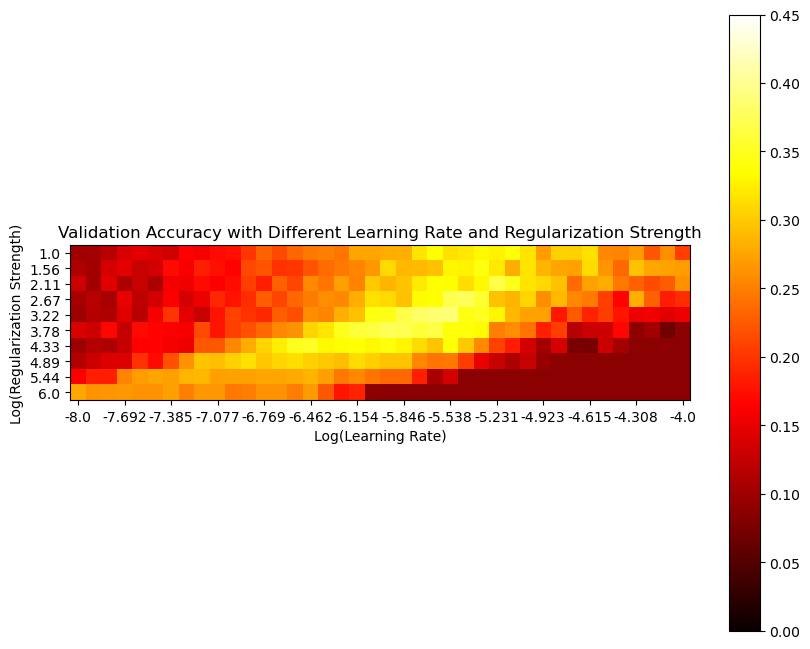

In [7]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_yticks(range(len(regularization_strengths)))
ax.set_yticklabels(np.round(np.log10(regularization_strengths), 2))
ax.set_xticks(range(0, len(learning_rates), 3))
ax.set_xticklabels(np.round(np.log10([learning_rates[i] for i in range(0, len(learning_rates), 3)]), 3))
im = ax.imshow(results_array, cmap=plt.cm.hot, vmin=0, vmax=0.45)
plt.colorbar(im)
plt.xlabel("Log(Learning Rate)")
plt.ylabel("Log(Regularization Strength)")
plt.title("Validation Accuracy with Different Learning Rate and Regularization Strength")
plt.show()

In [8]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.374000


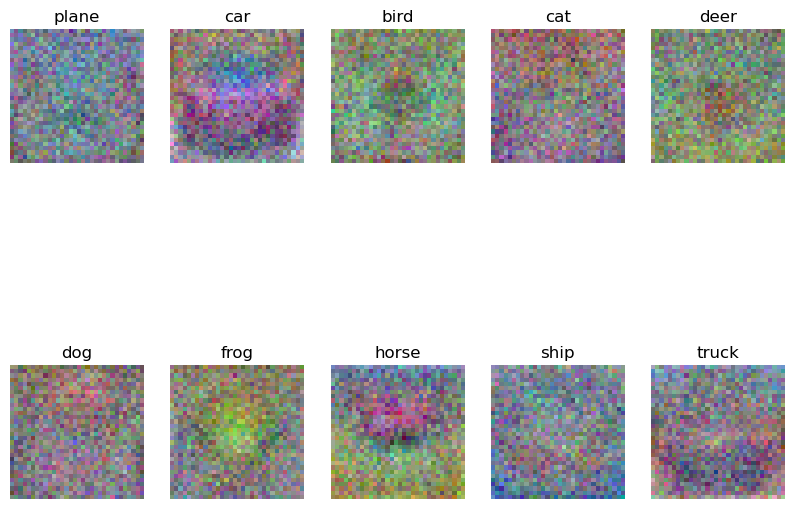

In [9]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])